In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.text import one_hot

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Import data

In [2]:
test_data = pd.read_csv("test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [3]:
train_data.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


I will first try to see if length of the comments is correlated to the emotion

In [4]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


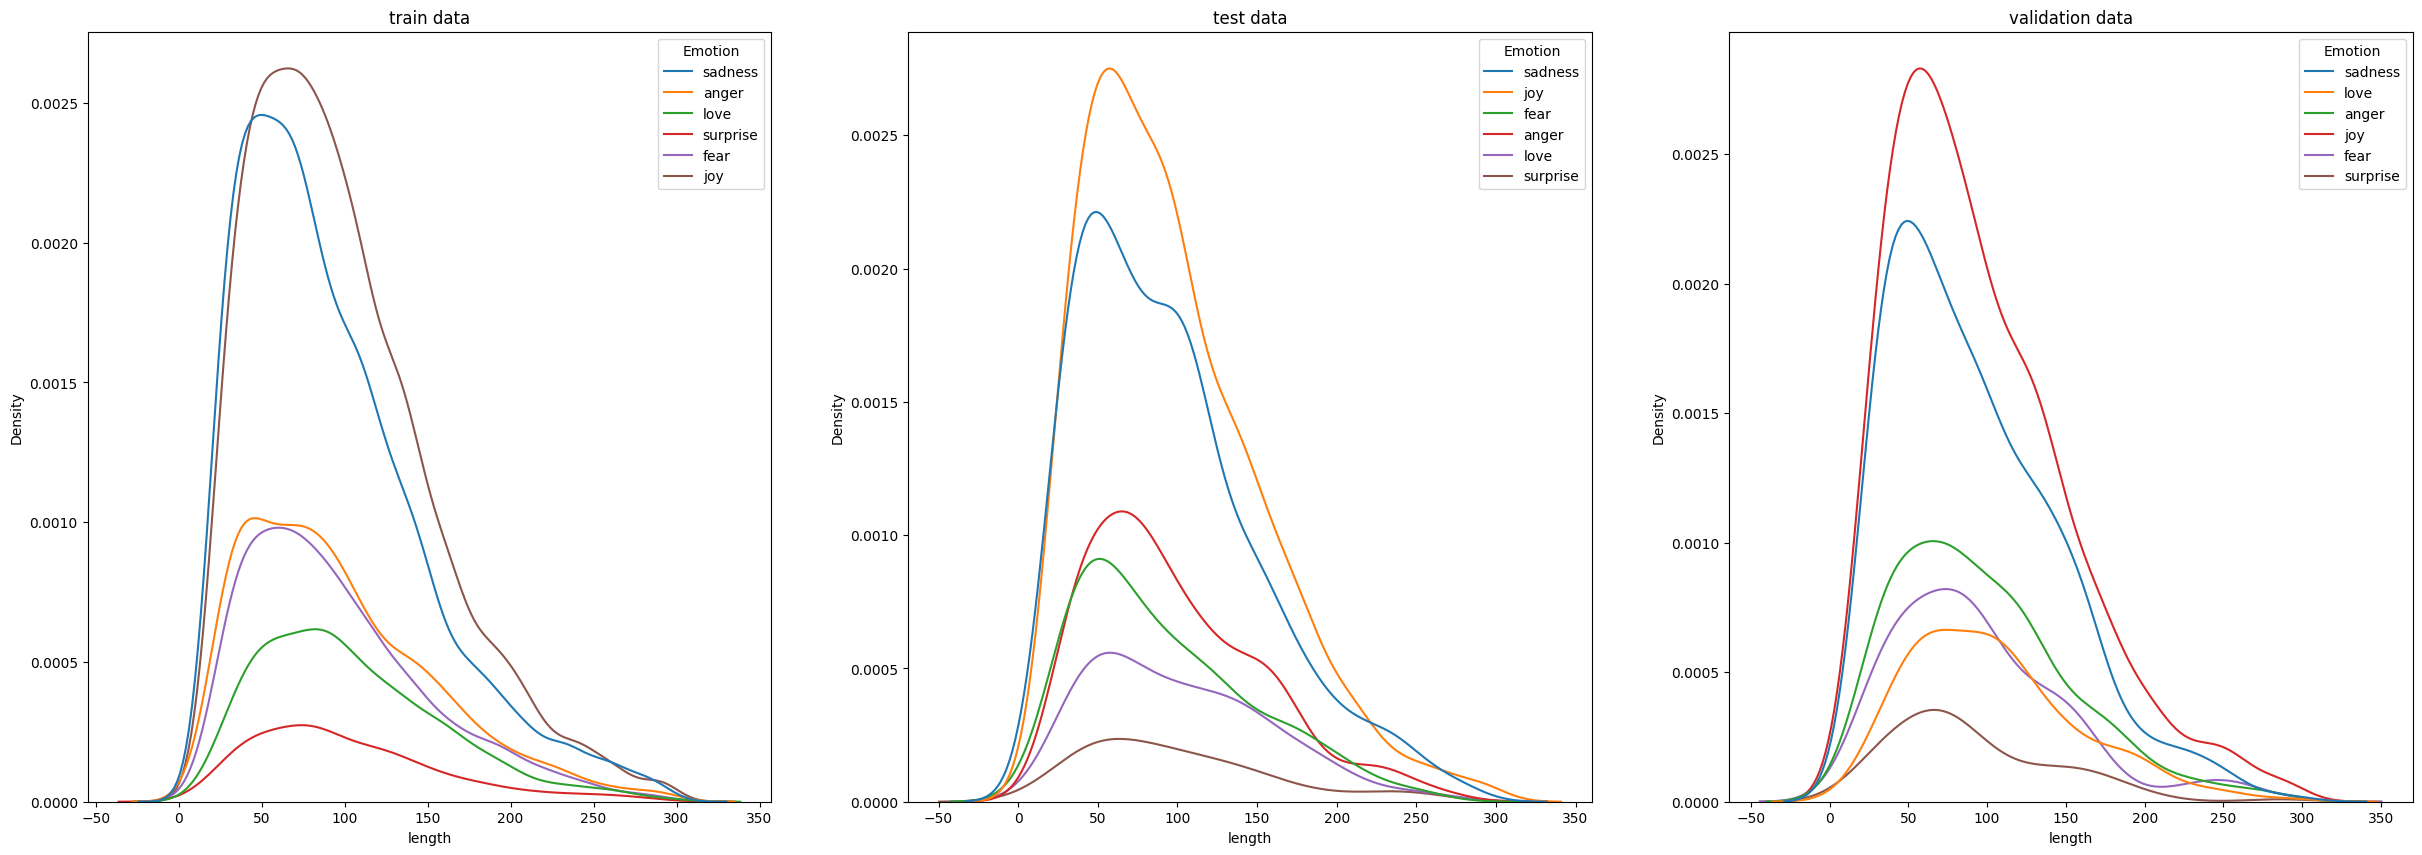

In [5]:
test_copy = test_data.copy()
test_copy['length'] = [len(x) for x in test_copy['Comment']]

val_copy = validation_data.copy()
val_copy['length'] = [len(x) for x in val_copy['Comment']]

fig, ax = plt.subplots(1,3, figsize=(30,10))

sns.kdeplot(data=train_data,x='length',hue='Emotion', ax=ax[0])
ax[0].set_title('train data')

sns.kdeplot(data=test_copy,x='length',hue='Emotion', ax=ax[1])
ax[1].set_title('test data')

sns.kdeplot(data=val_copy,x='length',hue='Emotion', ax=ax[2])
ax[2].set_title('validation data')

plt.show()


In [6]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(5, 5))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    plt.axis("off")

### Words Cloud for each emotion

In [7]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

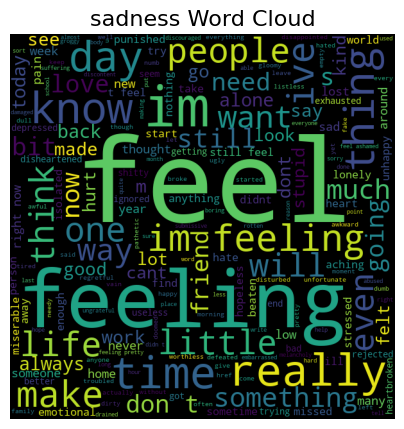

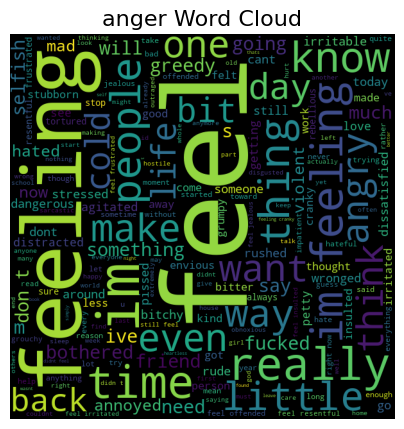

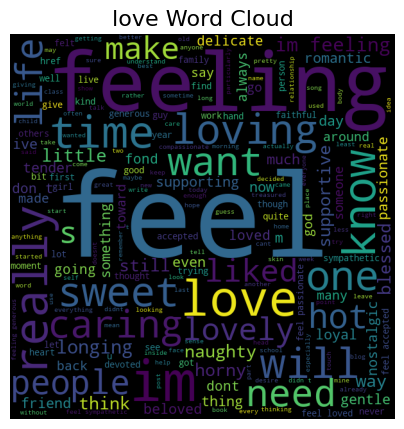

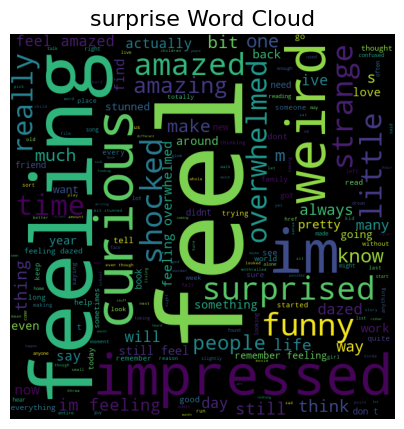

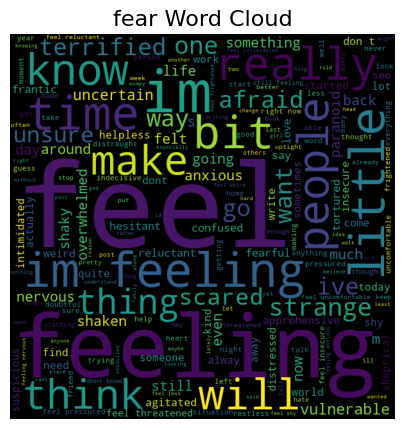

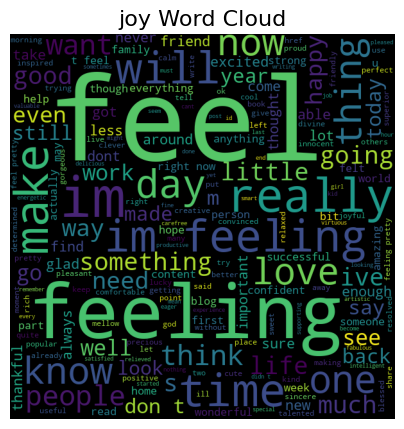

In [8]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# Preprocessing

#### Label Encoding

In [9]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

In [10]:
print(lb.classes_)

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


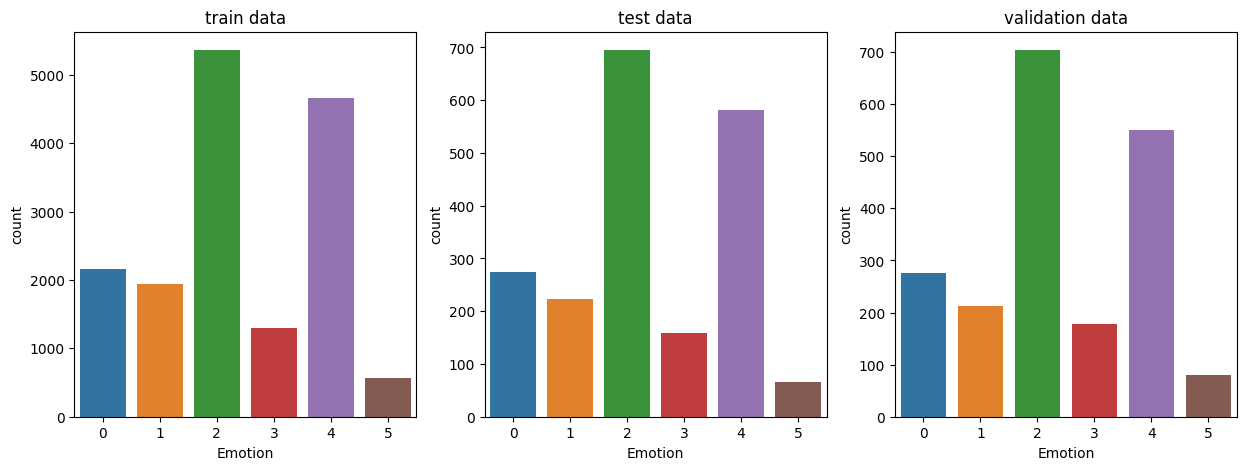

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.countplot(x=train_data['Emotion'], ax=ax[0])
ax[0].set_title('train data')
sns.countplot(x=test_data['Emotion'], ax=ax[1])
ax[1].set_title('test data')
sns.countplot(x=validation_data['Emotion'], ax=ax[2])
ax[2].set_title('validation data')
plt.show()

In [12]:
train_data.head(2)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108


In [13]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADIL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
max_len=train_data['length'].max()
max_len

300

In [15]:
vocabSize = 11000

In [16]:
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if (word not in stopwords or word == 'not')]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [17]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")

(16000, 300)
(2000, 300)
(2000, 300)


In [18]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [19]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [56]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

# Model building


In [20]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [21]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1650000   
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [22]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [23]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 390s 2s/step - loss: 1.5370 - accuracy: 0.3861 - val_loss: 1.1191 - val_accuracy: 0.6135
Epoch 2/10
250/250 [==============================] - 413s 2s/step - loss: 0.7484 - accuracy: 0.7578 - val_loss: 0.4777 - val_accuracy: 0.8480
Epoch 3/10
250/250 [==============================] - 417s 2s/step - loss: 0.3562 - accuracy: 0.8879 - val_loss: 0.3624 - val_accuracy: 0.8795
Epoch 4/10
250/250 [==============================] - 405s 2s/step - loss: 0.2361 - accuracy: 0.9255 - val_loss: 0.3396 - val_accuracy: 0.8885
Epoch 5/10
250/250 [==============================] - 408s 2s/step - loss: 0.1786 - accuracy: 0.9416 - val_loss: 0.3528 - val_accuracy: 0.8830
Epoch 6/10
250/250 [==============================] - 409s 2s/step - loss: 0.1461 - accuracy: 0.9497 - val_loss: 0.3430 - val_accuracy: 0.8935


In [24]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 16s 261ms/step - loss: 0.3396 - accuracy: 0.8885


[0.339616596698761, 0.8884999752044678]

In [25]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 15s 245ms/step - loss: 0.3569 - accuracy: 0.8785


[0.35685479640960693, 0.8784999847412109]

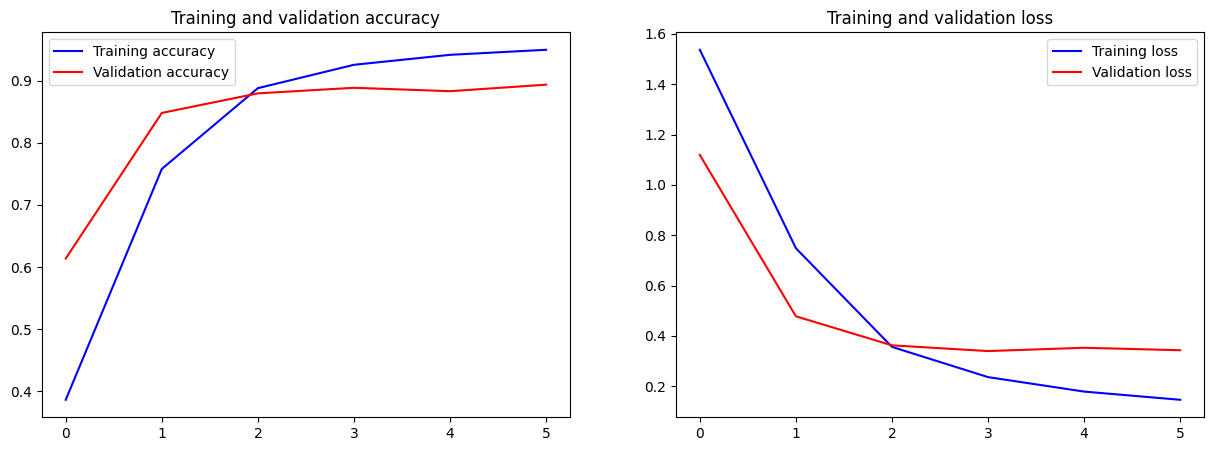

In [26]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(epochs,accuracy,'b', label='Training accuracy')
ax[0].plot(epochs,val_acc,'r', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs,loss,'b', label='Training loss')
ax[1].plot(epochs,val_loss,'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [27]:
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if (word not in stopwords or word == 'not')]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=300,padding='pre')
    return pad

In [28]:
sentences = [
             "Those teachers are really annoying i don't know what they excpect from us, this is frustrating",
             "i feel like a miserable piece of garbage",
             "i fear you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = model.predict(sentence)
    emotion_predict = np.argmax(result)
    emotion_class = lb.inverse_transform([emotion_predict])
    proba = np.max(result)
    print(f"{emotion_class} : {proba}\n\n")

Those teachers are really annoying i don't know what they excpect from us, this is frustrating
1/1 [==============================] - 1s 831ms/step
['anger'] : 0.9731253385543823


i feel like a miserable piece of garbage
1/1 [==============================] - 0s 58ms/step
['sadness'] : 0.9643197655677795


i fear you
1/1 [==============================] - 0s 58ms/step
['anger'] : 0.617314338684082




In [29]:
model_saved = model.to_json()
with open("model_saved.json", "w") as json_file:
    json_file.write(model_saved)
model.save_weights("model_saved.h5")

In [30]:
with open('model_saved.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_saved.h5")

In [31]:
print(lb.classes_)

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [32]:
emotions_dict = {0:'Anger', 1:'Fear', 2:'Joy', 3:'Love', 4:'Sadness', 5:'Surprise'}

In [51]:
sentences = [
             "He was speechles when he found out he was accepted to this new job",
            "He is really sweet and caring",
             "Those teachers are really annoying i don't know what they excpect from us, this is frustrating",
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = model.predict(sentence)
    emotion_result = emotions_dict[int(np.argmax(result))]
    proba =  np.max(result)
    print(f"{emotion_result} : {proba}\n\n")

He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 107ms/step
Anger : 0.721943199634552


He is really sweet and caring
1/1 [==============================] - 0s 104ms/step
Love : 0.5558754801750183


Those teachers are really annoying i don't know what they excpect from us, this is frustrating
1/1 [==============================] - 0s 141ms/step
Anger : 0.9731253385543823




# Interface

This is outrageous, how can you talk like that?

this is really romantic

I feel like im all alone in this world

i continue to feel so content about my decision to study here

i'am angry

I am so happy

In [57]:
from tkinter import *
from buttons import RoundedButton
from PIL import ImageTk, Image

# def sentence_cleaning(sentence):
#     global stopwords
#     stemmer = PorterStemmer()
#     corpus = []
#     text = re.sub("[^a-zA-Z]", " ", sentence)
#     text = text.lower()
#     text = text.split()
#     text = [stemmer.stem(word) for word in text if (word not in stopwords or word == 'not')]
#     text = " ".join(text)
#     corpus.append(text)
#     one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
#     pad = pad_sequences(sequences=one_hot_word,maxlen=300,padding='pre')
#     return pad

# dictionary of the emotions
emotions_dict = {0:'Anger', 1:'Fear', 2:'Joy', 3:'Love', 4:'Sadness', 5:'Surprise'}

window = Tk()
window.title("Emotion detetctor")
window.geometry('600x500')
window.resizable(1,1)


label = Label(window, text="Welcome to emotion detector", font=("Arial Bold", 16))
label.pack(side=TOP, pady=30)



img = ImageTk.PhotoImage(Image.open(r"D:\AISciD(S6)\Deep_Learning\Emotions_Classification_NLP\button.png"))
feel = None



textfield = Text(window, width=40, font=('Arial', 12), bd=2, relief='groove', height=2)
textfield.pack(side=TOP, pady=10)


lb = Label(window, image=None, height=240)
lb_text = Label(window, text=None, font=("Arial Bold", 16))


def on_submit():
    text = textfield.get("1.0", "end-1c")
    text = sentence_cleaning(text)
    result = model.predict(text)
    
    emotion_result = int(np.argmax(result))
    
    proba =  np.max(result) * 100
    
    global lb
    global lb_text
    lb_text.destroy()
    feeling = ''
    if emotion_result == 0:
        feeling = 'angry'
        lb.destroy()
    elif emotion_result == 1:
        feeling = 'feared'
        lb.destroy()
    elif emotion_result == 2:
        feeling = 'happy'
        lb.destroy()
    elif emotion_result == 3:
        feeling = 'lover'
        lb.destroy()
    elif emotion_result == 4:
        feeling = 'sad'
        lb.destroy()
    elif emotion_result == 5:
        feeling = 'surprised'
        lb.destroy()

    gif_path = (f"D:/AISciD(S6)/Deep_Learning/Emotions_Classification_NLP/{feeling}.gif")
    print(f"file path = {gif_path}")
    
    image = Image.open(gif_path)
    # Resize the image
    image = image.resize((150, 150))
    # Create a PhotoImage object from the image
    photo = ImageTk.PhotoImage(image,  format="gif -index 2")
    lb = Label(window, image=photo, height=240)
    lb.image = photo
    lb.pack()
    lb_text = Label(window, text=f'You are : {proba:.2f}% {feeling}', font=("Arial Bold", 16))
    lb_text.pack(pady=10)
    textfield.delete("1.0", "end-1c")


button = Button(window, command = on_submit, image = img, border=0)
button.pack()





window.mainloop()



1/1 [==============================] - 0s 76ms/step
file path = D:/AISciD(S6)/Deep_Learning/Emotions_Classification_NLP/angry.gif
1/1 [==============================] - 0s 100ms/step
file path = D:/AISciD(S6)/Deep_Learning/Emotions_Classification_NLP/sad.gif
1/1 [==============================] - 0s 80ms/step
file path = D:/AISciD(S6)/Deep_Learning/Emotions_Classification_NLP/happy.gif
1/1 [==============================] - 0s 77ms/step
file path = D:/AISciD(S6)/Deep_Learning/Emotions_Classification_NLP/angry.gif
1/1 [==============================] - 0s 69ms/step
file path = D:/AISciD(S6)/Deep_Learning/Emotions_Classification_NLP/happy.gif
1/1 [==============================] - 0s 55ms/step
file path = D:/AISciD(S6)/Deep_Learning/Emotions_Classification_NLP/angry.gif
1/1 [==============================] - 0s 52ms/step
file path = D:/AISciD(S6)/Deep_Learning/Emotions_Classification_NLP/happy.gif
1/1 [==============================] - 0s 50ms/step
file path = D:/AISciD(S6)/Deep_Learning